In [25]:
# Falta el even harder ejercicio
# Falta cambiar coordenadas de las esquinas
# Por algún motivo el sacar el flujo del modelo ha dejado de funcionar

In [34]:
import copy
import glob
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
import shutil, shlex


from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import *
from simulation_imports import *
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)


In [35]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
xmldir = "{}/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row".format(SIXTE)

xml0="{}/ld_wfi_ff_chip0.xml".format(xmldir)
xml1="{}/ld_wfi_ff_chip1.xml".format(xmldir)
xml2="{}/ld_wfi_ff_chip2.xml".format(xmldir)
xml3="{}/ld_wfi_ff_chip3.xml".format(xmldir)
#xmldir="./xmldir"

In [36]:
# Global variables
# Aim of the telescope for eta Car

RA=161.56
Dec=-59.52

# Coordinates of the squares of the plot (needed for second axis) ---> Same for whole part

sq_dwl = np.array((162.20, -59.82))
sq_upr = np.array((160.90, -59.21))

In [37]:
# xspec file (simple powerlaw emission model)

xcm = "constflux.xcm"

mcmod = Model("pegpwrlw")
mcmod.pegpwrlw.PhoIndex = 1
mcmod.pegpwrlw.norm = 1

rewrite = True
if rewrite:
    if os.path.exists(xcm):
            os.remove(xcm)
    Xset.save(xcm)
else:
    print("Xspec file ({}) already exists: it will not be overwritten".format(xcm)) 

In [38]:
# simput file (only high energy)
f = fits.open('etaCar_xray_hi.fits')
# Extract coordinates from the image file
RA_high = f[0].header['CRVAL1']
Dec_high = f[0].header['CRVAL2']


sim_file_high = 'etaCar_high.fits'
rewrite = True

if rewrite:
    if os.path.exists(sim_file_high):
        os.remove(sim_file_high)
    run_comm('simputfile Simput={} RA={} Dec={} srcFlux=1e-11 Emin=3 Emax=8 Elow=2 Eup=10 XSPECFile={} '.format(sim_file_high, RA_high, Dec_high, xcm) +
             'ImageFile=etaCar_xray_hi.fits clobber=yes', 'Creating simput file for eta car')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file_high))

Creating simput file for eta car
simputfile Simput=etaCar_high.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=1e-11 Emin=3 Emax=8 Elow=2 Eup=10 XSPECFile=constflux.xcm ImageFile=etaCar_xray_hi.fits clobber=yes


In [39]:
# Running simulation

base = 'etaCar_high_'
evt_final_high = '{}chip_merged'.format(base)

rewrite = True
if rewrite:
    for i in range(4):
        # Remove all 4 files if they exist
        evt_file = '{}{}'.format(base, i)
        if os.path.exists(evt_final_high):
            os.remove(evt_final_high)
    # Then simulate and merge the 4 evt files (one for each chip)
    run_comm('athenawfisim XMLFile0={} XMLFile1={} XMLFile2={} XMLFile3={} RA={} Dec={} '.format(xml0, xml1, xml2, xml3, RA, Dec) +
             'Prefix=etaCar_high_ Simput={} Exposure=1000 clobber=yes'.format(sim_file_high), 'Creating simput file for eta car')
    run_comm('ftmerge {}chip0_evt.fits,{}chip1_evt.fits,{}chip2_evt.fits,{}chip3_evt.fits {} clobber=yes'.format(base, base, base, base, evt_final_high), 'Merging 4 event files')

else:
    print("Event files already exist: they will not be overwritten".format(evt_final_high))


Creating simput file for eta car
athenawfisim XMLFile0=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip0.xml XMLFile1=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip1.xml XMLFile2=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip2.xml XMLFile3=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip3.xml RA=161.56 Dec=-59.52 Prefix=etaCar_high_ Simput=etaCar_high.fits Exposure=1000 clobber=yes
Merging 4 event files
ftmerge etaCar_high_chip0_evt.fits,etaCar_high_chip1_evt.fits,etaCar_high_chip2_evt.fits,etaCar_high_chip3_evt.fits etaCar_high_chip_merged clobber=yes



imgev EvtFile=etaCar_high_chip_merged Image=etaCar_high_merged_img.fits CoordinateSystem=0 Projection=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=161.56 CRVAL2=-59.52 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes


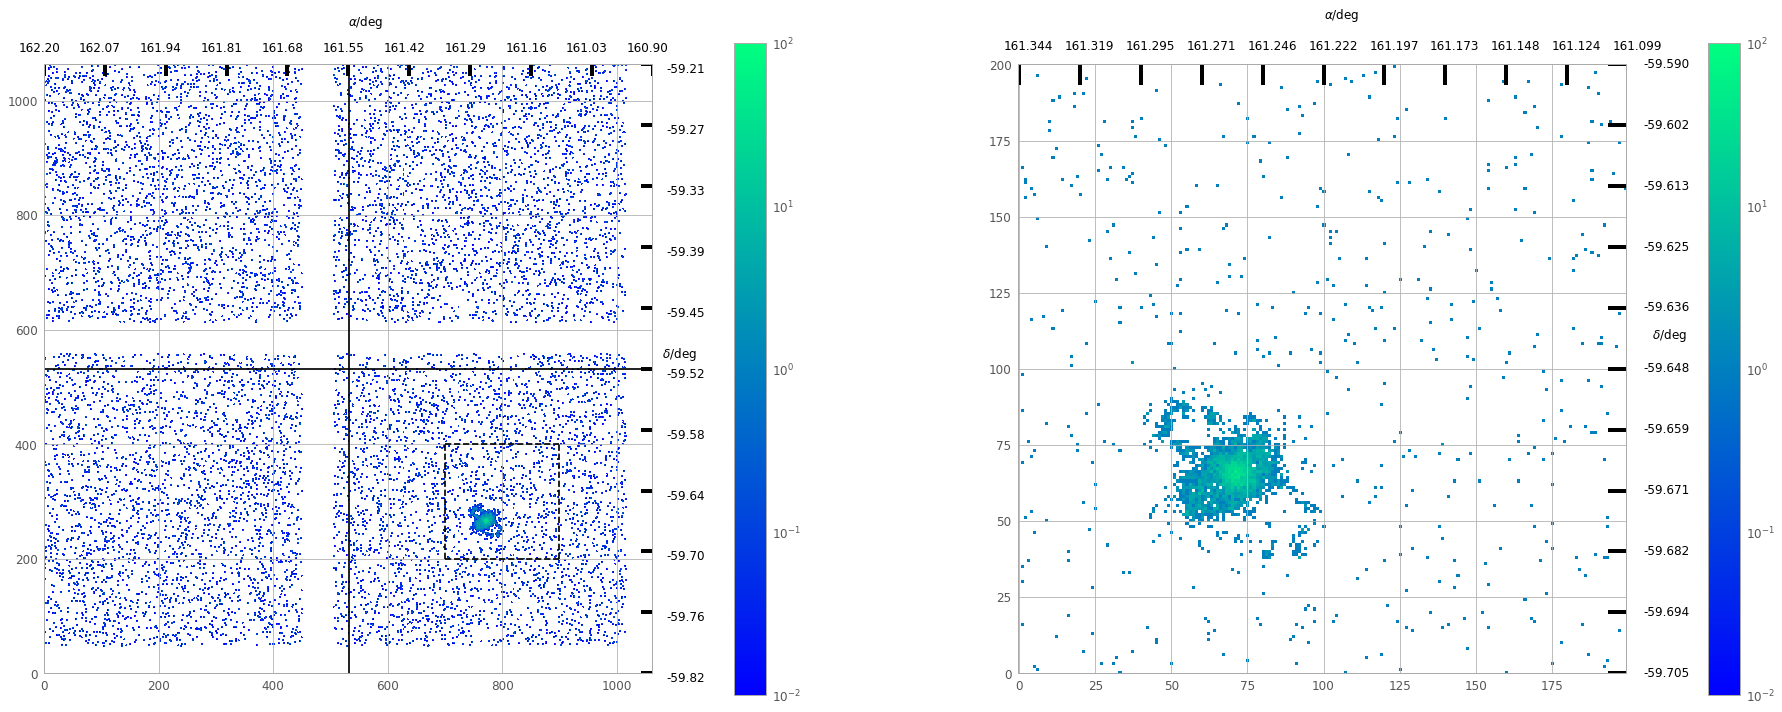

In [41]:
rewrite = True
img_final_high = 'etaCar_high_merged_img.fits'
# Create the image of the merged evt file 
if rewrite:
    if os.path.exists(img_final_high):
        os.remove(img_final_high)
    run_comm('imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN NAXIS1=1063 '.format(evt_final_high, img_final_high) +
             'NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1={} CRVAL2={} CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes'.format(RA, Dec))
    
else:
    print('Image file {} already exists, it will not be overwritten'.format(img_final_high))

# Show image. Two subplots: general image and zoomed source respec.
image_data = fits.getdata(img_final_high, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16*2,6*2))
axs = _axs.flatten()

# Shows the central part of the detector
axs[0].plot([532, 532], [0,len(image_data)], 'k-')
axs[0].plot([0,len(image_data)], [532, 532],  'k-')

# Function to draw second axis. See Docu. of the func. ####### CHANGE THE COORDINATES WITH NEW XML #########


draw_second_axis(fig, axs, sq_downleft=sq_dwl, sq_upright=sq_upr, ln=1063, mov_ra=45, mov_dec=15, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=23, zero_between=False, display_format='.2f')




sq1, sq2 = get_zoom_coord(sq_dwl, sq_upr, 1063, [700, 900], [200, 400])


draw_second_axis(fig, axs, sq_downleft=sq1, sq_upright=sq2, ln=200, mov_ra=5, mov_dec=1, lon_lines=6, num_lines=10,
                 mov_x_text=[0, 15], mov_y_text=[8, 10], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=1, dist_txt=5, zero_between=False, display_format='.3f')


axs[0].set_ylim(0, len(image_data))

# Draw to section to be zoomed in the first figure
axs[0].plot([700, 900], [200, 200], 'k--')
axs[0].plot([700, 900], [400, 400], 'k--')
axs[0].plot([700, 700], [200, 400], 'k--')
axs[0].plot([900, 900], [200, 400], 'k--')

cmap = plt.cm.winter
# First image
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[0], pad=0.1)

# Second image
img = image_data[200:400, 700:900]
axs[1].set_ylim(0, len(img))
im = axs[1].imshow(img, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[1], pad=0.1)

img_subplot(fig, axs[1], 1.5, 1.2, 'imgs/etaCar_high_zoom_extended_sources.png')

### $\textbf{Exercise}$: Generate a spectrum of chip0 and verify that indeed only photons between 2 and 10 keV are generated. Where do the photons detected below 2 keV come from?

In [52]:
# Create spectrum
spec_file = 'etaCar_high_merged_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={}chip0_evt.fits Spectrum={} clobber=yes RSPPath={}".format(base, spec_file, xmldir), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))

Generating spectrum
makespec EvtFile=etaCar_high_chip0_evt.fits Spectrum=etaCar_high_merged_spec.pha clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row


In [53]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

# rebin spectral data

binspec = "spec_etaCar_rebin_.pha".format(base)

rewrite = True
if rewrite:
    if os.path.exists(binspec):
            os.remove(binspec)
    comm = ("grppha infile={} outfile={} clobber=yes comm='group min 20 & exit'".format(spec_file, binspec))    
    run_comm(comm, "Rebinning spectrum")
else:
    print("Rebin file ({}) already exists: it will not be overwritten".format(binspec))

AllData.clear()
s1 = Spectrum(spec_file)
s1.ignore("**-1.0")
s1.ignore("11.0-**")
s1.ignore("bad")
Plot("ldata")

Rebinning spectrum
grppha infile=etaCar_high_merged_spec.pha outfile=spec_etaCar_rebin_.pha clobber=yes comm='group min 20 & exit'


### $\textbf{Exercise}$: Generate two more SIMPUT files using the medium and low band, merge them with simputmerge, and perform a new WFI simulation.


In [13]:
# simput file
f = fits.open('etaCar_xray_med.fits')
RA_med = f[0].header['CRVAL1']
Dec_med = f[0].header['CRVAL2']

sim_file_med = 'etaCar_med.fits'
rewrite = True

if rewrite:
    if os.path.exists(sim_file_med):
        os.remove(sim_file_med)
    run_comm('simputfile Simput={} RA={} Dec={} srcFlux=2.2e-12 Emin=0.2 Emax=10 Elow=0.2 Eup=15 XSPECFile={} '.format(sim_file_med, RA_med, Dec_med, xcm) +
             'ImageFile=etaCar_xray_med.fits clobber=yes', 'Creating simput file for eta car med')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file_med))
    


f = fits.open('etaCar_xray_low.fits')
RA_low = f[0].header['CRVAL1']
Dec_low = f[0].header['CRVAL2']

sim_file_low = 'etaCar_low.fits'
rewrite = True

if rewrite:
    if os.path.exists(sim_file_low):
        os.remove(sim_file_low)
    run_comm('simputfile Simput={} RA={} Dec={} srcFlux=2.2e-12 Emin=0.2 Emax=10 Elow=0.2 Eup=15 XSPECFile={} '.format(sim_file_low, RA_low, Dec_low, xcm) +
             'ImageFile=etaCar_xray_low.fits clobber=yes', 'Creating simput file for eta car low')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file_low))
    
# Merge high, med and low  evt files (high obtained in the cells above)
    

rewrite = True
sim_file_merged = 'etaCar_sim_merged.fits'
if rewrite:
    if os.path.exists(sim_file_merged):
        os.remove(sim_file_merged)
    run_comm('ftmerge {},{},{} {} clobber=yes '.format(sim_file_high, sim_file_med, sim_file_low, sim_file_merged), 
            'Merging 3 simput files') 
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file_merged))



Creating simput file for eta car med
simputfile Simput=etaCar_med.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=2.2e-12 Emin=0.2 Emax=10 Elow=0.2 Eup=15 XSPECFile=etaCar_apec.xcm ImageFile=etaCar_xray_med.fits clobber=yes
Creating simput file for eta car low
simputfile Simput=etaCar_low.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=2.2e-12 Emin=0.2 Emax=10 Elow=0.2 Eup=15 XSPECFile=etaCar_apec.xcm ImageFile=etaCar_xray_low.fits clobber=yes
Merging 3 simput files
ftmerge etaCar_high.fits,etaCar_med.fits,etaCar_low.fits etaCar_sim_merged.fits clobber=yes 


In [14]:
# Run the new simulation and merge the 4 chips

base = 'etaCar'
rewrite = True
evt_final_merged = '{}merged'.format(base)
if rewrite:
    run_comm('athenawfisim XMLFile0={} XMLFile1={} XMLFile2={} XMLFile3={} RA={} Dec={} '.format(xml0, xml1, xml2, xml3, RA, Dec) +
             'Prefix=etaCar_ Simput={} Exposure=1000 clobber=yes'.format(sim_file_merged), 'Running simulation for eta car')
    run_comm('ftmerge {}_chip0_evt.fits,{}_chip1_evt.fits,{}_chip2_evt.fits,{}_chip3_evt.fits {} clobber=yes'.format(base, base, base, base, evt_final_merged), 'Merging 4 event files')

else:
    print("Event files already exist: they will not be overwritten".format(evt_file_merged))

Running simulation for eta car
athenawfisim XMLFile0=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip0.xml XMLFile1=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip1.xml XMLFile2=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip2.xml XMLFile3=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_chip3.xml RA=161.56 Dec=-59.52 Prefix=etaCar_ Simput=etaCar_sim_merged.fits Exposure=1000 clobber=yes
Merging 4 event files
ftmerge etaCar_chip0_evt.fits,etaCar_chip1_evt.fits,etaCar_chip2_evt.fits,etaCar_chip3_evt.fits etaCarmerged clobber=yes



imgev EvtFile=etaCarmerged Image=etaCar_full_combined_img.fits CoordinateSystem=0 Projection=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=161.56 CRVAL2=-59.52 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes


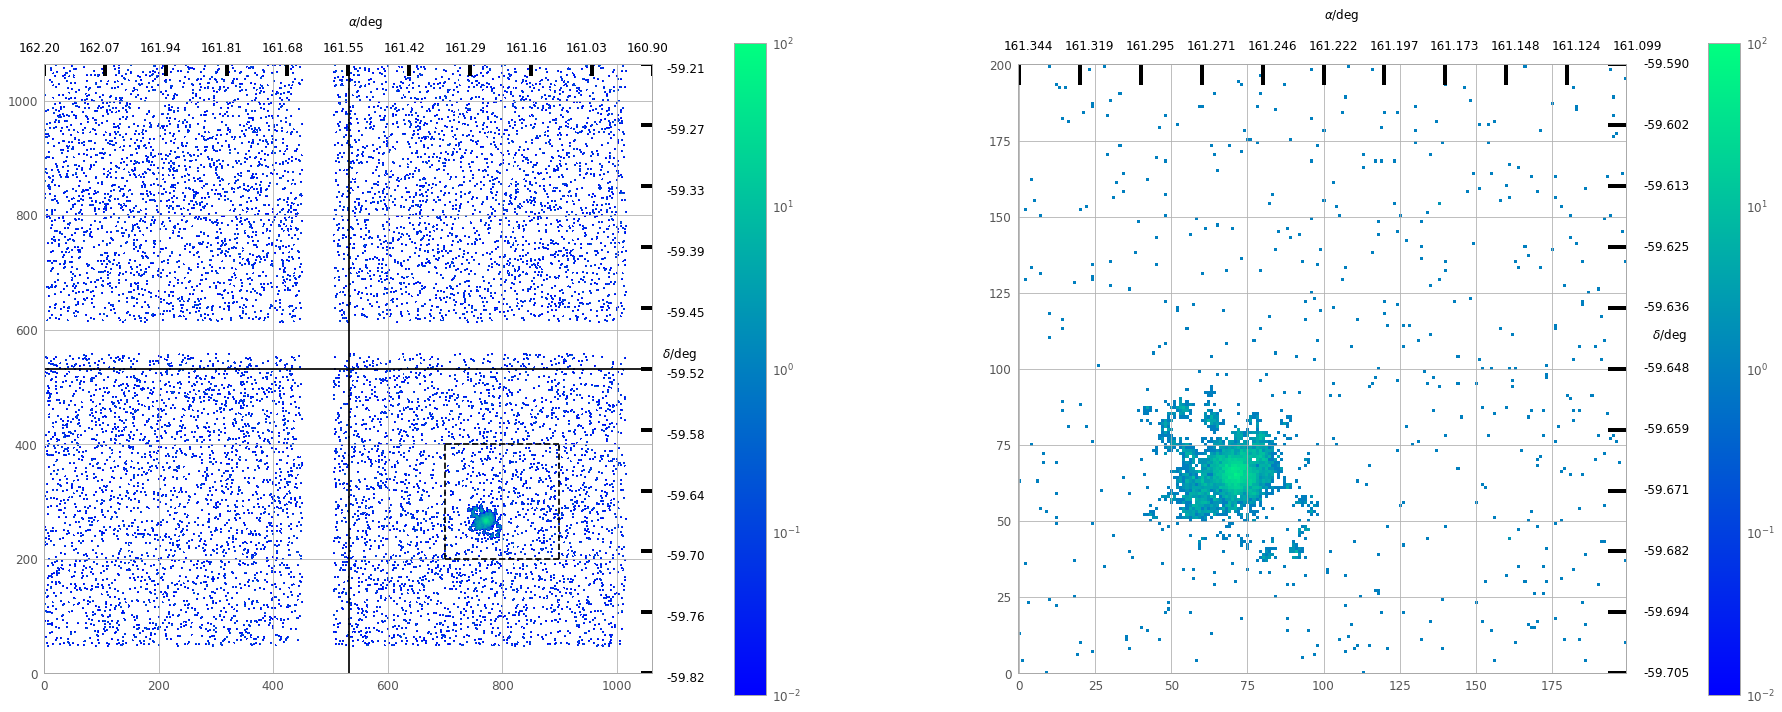

In [15]:
# Same procedure as before
rewrite = True
img_file = 'etaCar_full_combined_img.fits'
if rewrite:
    if os.path.exists(img_file):
        os.remove(img_file)
    run_comm('imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN NAXIS1=1063 '.format(evt_final_merged, img_file) +
             'NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1={} CRVAL2={} CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes'.format(RA, Dec))
    
else:
    print('Image file {} already exists, it will not be overwritten'.format(img_file))


image_data = fits.getdata(img_file, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16*2,6*2))
axs = _axs.flatten()
axs[0].plot([532, 532], [0,len(image_data)], 'k-')
axs[0].plot([0,len(image_data)], [532, 532],  'k-')


draw_second_axis(fig, axs, sq_downleft=sq_dwl, sq_upright=sq_upr, ln=1063, mov_ra=45, mov_dec=15, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=23, zero_between=False, display_format='.2f')



sq1, sq2 = get_zoom_coord(sq_dwl, sq_upr, 1063, [700, 900], [200, 400])



draw_second_axis(fig, axs, sq_downleft=sq1, sq_upright=sq2, ln=200, mov_ra=5, mov_dec=1, lon_lines=6, num_lines=10,
                 mov_x_text=[0, 15], mov_y_text=[8, 10], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=1, dist_txt=5, zero_between=False, display_format='.3f')


axs[0].set_ylim(0, len(image_data))
axs[0].plot([700, 900], [200, 200], 'k--')
axs[0].plot([700, 900], [400, 400], 'k--')
axs[0].plot([700, 700], [200, 400], 'k--')
axs[0].plot([900, 900], [200, 400], 'k--')

cmap = plt.cm.winter
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[0], pad=0.1)
img = image_data[200:400, 700:900]
axs[1].set_ylim(0, len(img))
im = axs[1].imshow(img, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[1], pad=0.1)


### $\textbf{Exercise}:$ Rather than describing the spectral shapes with constants, describe the overall spectral shape of $\eta$ Car and the Humunculus nebula using an apec model with a temperature of kT = 4 keV, absorbed by NH = 2 $\cdot$ 10$^{22}$ cm$^{−2}$. Use XSPEC to determine the relative fluxes for the three energy bands for which Chandra images are available. Then generate three SIMPUT files, fixing the hard band flux to $10^{−11}$ cgs and the two lower fluxes to values appropriate for the absorbed apec model. Do not forget to set Eup and Elow appropriately. Perform the simulation again

In [16]:
# xspec file with apec model (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelApec.html) and phabs 
# (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node255.html)

xcm = "etaCar_apec.xcm"

mcmod = Model("apec * phabs")
mcmod.apec.kT = 4
mcmod.phabs.nH = 2

# Fluxes for the 3 bands
AllModels.calcFlux('2 7')
flux_high = mcmod.flux[0]

AllModels.calcFlux('0.5 1.2')
flux_low = mcmod.flux[0]

AllModels.calcFlux('1.2 2')
flux_med = mcmod.flux[0]

rewrite = True
if rewrite:
    if os.path.exists(xcm):
            os.remove(xcm)
    Xset.save(xcm)
else:
    print("Xspec file ({}) already exists: it will not be overwritten".format(xcm)) 

In [17]:
rewrite = True
base = 'etaCar_apec_'
# Energy boundaries for the 3 simputs
E_minmax = [[2., 7.], [1.2, 2.0], [0.5, 1.2]]
E_downup = [[1., 10.], [0.5, 4.0], [0.1, 4.0]]
sim_file = []
sim_file_merged = '{}merged.fits'.format(base)
k = 0
if rewrite:
    for i, j, x, y in zip((flux_high, flux_med, flux_low), ('hi.fits', 'med.fits', 'low.fits'), E_minmax, E_downup):
        sim_file.append('{}{}'.format(base, j)) # Name of every SIMPUT file (j changes in each loop)
        if os.path.exists(sim_file[k]):
            os.remove(sim_file[k])
        run_comm('simputfile Simput={} RA={} Dec={} srcFlux={} Emin={} Emax={} Elow={} Eup={} XSPECFile={} '.format(sim_file[k], RA_low, Dec_low, i,
                                                                                                                    x[0], x[1], y[0], y[1], xcm) +
                 'ImageFile=etaCar_xray_{} clobber=yes'.format(j), 'Creating simput file for eta car low')
        k = k + 1   
    run_comm('ftmerge {},{},{} {} clobber=yes '.format(sim_file[0], sim_file[1], sim_file[2], sim_file_merged), 
        'Merging 3 simput files') # After creating the 3 SIMPUTS they are merged into one
        
else:
    print("Simput files already exist: they will not be overwritten")

Creating simput file for eta car low
simputfile Simput=etaCar_apec_hi.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=6.803056140842329e-10 Emin=2.0 Emax=7.0 Elow=1.0 Eup=10.0 XSPECFile=etaCar_apec.xcm ImageFile=etaCar_xray_hi.fits clobber=yes
Creating simput file for eta car low
simputfile Simput=etaCar_apec_med.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=6.338692669130512e-11 Emin=1.2 Emax=2.0 Elow=0.5 Eup=4.0 XSPECFile=etaCar_apec.xcm ImageFile=etaCar_xray_med.fits clobber=yes
Creating simput file for eta car low
simputfile Simput=etaCar_apec_low.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=3.399550414823823e-12 Emin=0.5 Emax=1.2 Elow=0.1 Eup=4.0 XSPECFile=etaCar_apec.xcm ImageFile=etaCar_xray_low.fits clobber=yes
Merging 3 simput files
ftmerge etaCar_apec_hi.fits,etaCar_apec_med.fits,etaCar_apec_low.fits etaCar_apec_merged.fits clobber=yes 


In [19]:
# Run the new simulation and merge the 4 chips

rewrite = False
evt_final_merged = '{}merged_evt'.format(base)
if rewrite:
    run_comm('athenawfisim XMLFile0={} XMLFile1={} XMLFile2={} XMLFile3={} RA={} Dec={} '.format(xml0, xml1, xml2, xml3, RA, Dec) +
             'Prefix={} Simput={} Exposure=10000 clobber=yes'.format(base, sim_file_merged), 'Running simulation for eta car')
    run_comm('ftmerge {}chip0_evt.fits,{}chip1_evt.fits,{}chip2_evt.fits,{}chip3_evt.fits {} clobber=yes'.format(base, base, base, base, evt_final_merged), 'Merging 4 event files')

else:
    print("Event files already exist: they will not be overwritten".format(evt_final_merged))

Event files already exist: they will not be overwritten


Image file etaCar_apec_merged_img.fits already exists, it will not be overwritten
Opening image
xdg-open imgs/etaCar_apec_zoom_extended_sources.png


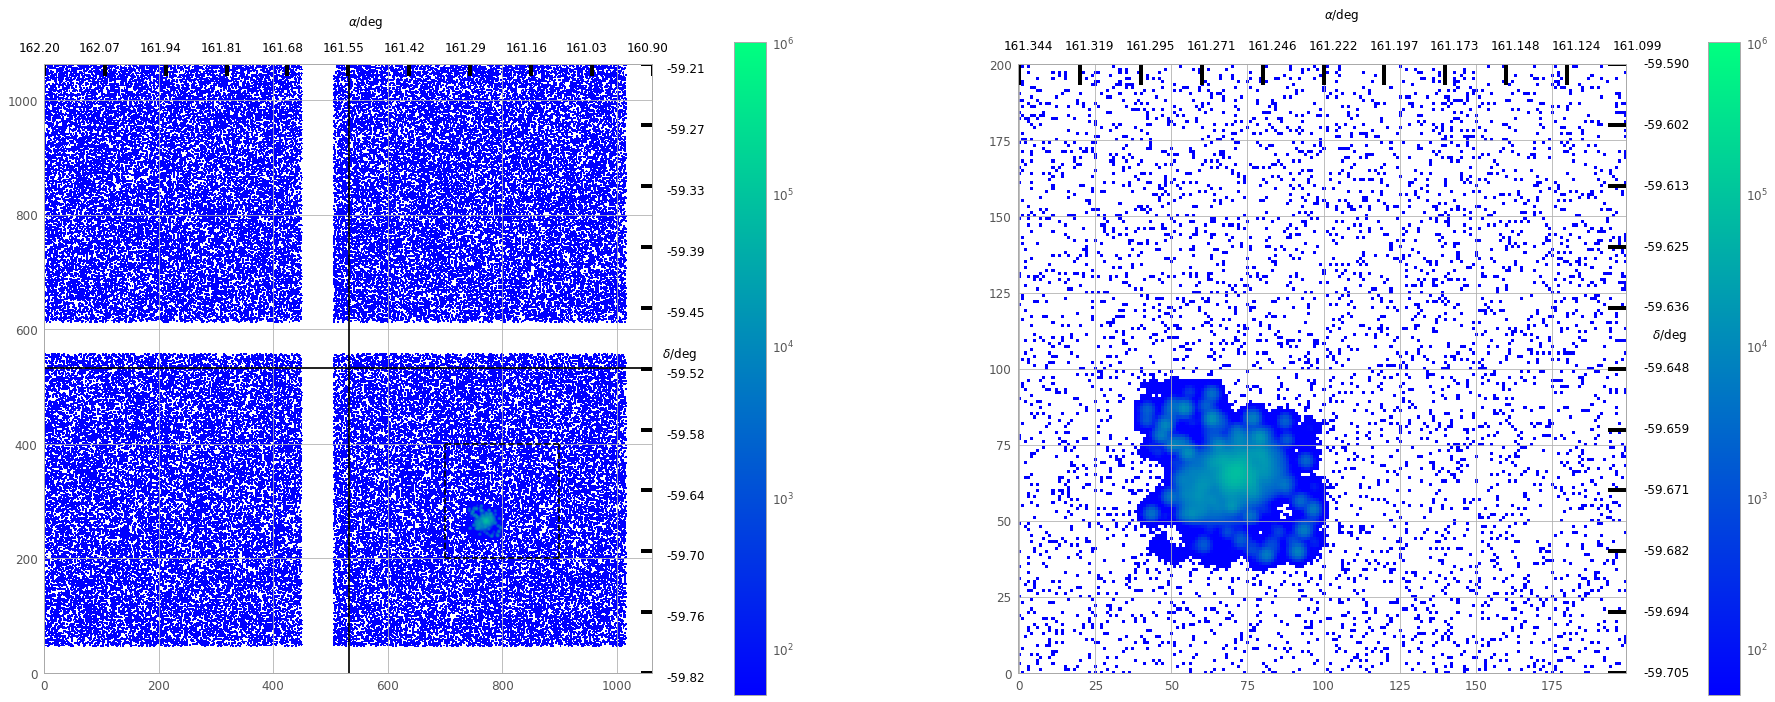

In [26]:
rewrite = False
img_file = '{}merged_img.fits'.format(base)
if rewrite:
    if os.path.exists(img_file):
        os.remove(img_file)
    run_comm('imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN NAXIS1=1063 '.format(evt_final_merged, img_file) +
             'NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1={} CRVAL2={} CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes'.format(RA, Dec))
    
else:
    print('Image file {} already exists, it will not be overwritten'.format(img_file))


image_data = fits.getdata(img_file, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16*2,6*2))
axs = _axs.flatten()
axs[0].plot([532, 532], [0,len(image_data)], 'k-')
axs[0].plot([0,len(image_data)], [532, 532],  'k-')


draw_second_axis(fig, axs, sq_downleft=sq_dwl, sq_upright=sq_upr, ln=1063, mov_ra=45, mov_dec=15, lon_lines=17, num_lines=10,
                mov_x_text=[0, 67], mov_y_text=[17, 20], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=23, zero_between=False, display_format='.2f')


sq1, sq2 = get_zoom_coord(sq_dwl, sq_upr, 1063, [700, 900], [200, 400])



draw_second_axis(fig, axs, sq_downleft=sq1, sq_upright=sq2, ln=200, mov_ra=5, mov_dec=1, lon_lines=6, num_lines=10,
                 mov_x_text=[0, 15], mov_y_text=[8, 10], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=1, dist_txt=5, zero_between=False, display_format='.3f')


axs[0].set_ylim(0, len(image_data))
axs[0].plot([700, 900], [200, 200], 'k--')
axs[0].plot([700, 900], [400, 400], 'k--')
axs[0].plot([700, 700], [200, 400], 'k--')
axs[0].plot([900, 900], [200, 400], 'k--')

cmap = plt.cm.winter
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=50, vmax=1000000))
fig.colorbar(im,ax=axs[0], pad=0.1)
img = image_data[200:400, 700:900]
axs[1].set_ylim(0, len(img))
im = axs[1].imshow(img, cmap=cmap, norm=colors.LogNorm(vmin=50, vmax=1000000))
fig.colorbar(im,ax=axs[1], pad=0.1)

img_subplot(fig, axs[1], 1.5, 1.2, 'imgs/etaCar_apec_zoom_extended_sources.png', True)


In [61]:
# Create spectrum
spec_file = 'etaCar_apec_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={} clobber=yes RSPPath={}".format(evt_final_merged, spec_file, xmldir), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))

    
Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

# rebin spectral data

binspec = "spec_etaCar_apec_rebin_.pha".format(base)

rewrite = True
if rewrite:
    if os.path.exists(binspec):
            os.remove(binspec)
    comm = ("grppha infile={} outfile={} clobber=yes comm='group min 20 & exit'".format(spec_file, binspec))    
    run_comm(comm, "Rebinning spectrum")
else:
    print("Rebin file ({}) already exists: it will not be overwritten".format(binspec))

AllData.clear()
s1 = Spectrum(spec_file)
s1.ignore("**-1.0")
s1.ignore("11.0-**")
s1.ignore("bad")
Plot("ldata")

Generating spectrum
makespec EvtFile=etaCar_apec_merged_evt Spectrum=etaCar_apec_spec.pha clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row
Rebinning spectrum
grppha infile=etaCar_apec_spec.pha outfile=spec_etaCar_apec_rebin_.pha clobber=yes comm='group min 20 & exit'


### $\textbf{Exercise}$: For each of the three images, use the Chandra dmcopy tool and an appropriately defined region filter to produce an image file of the humunculus nebula that does not include the central point source and an image file that only includes the point source. Prepare SIMPUT files that model the nebula with a different spectral shape than the point source, merge them with simputmerge, and run the simulation again, now having a very realistic model for the whole source.